In [1]:

import cantera as ct
import numpy as np

#Parameters
T=383 #Initial temperature in K
p=1 #pressure in bar
volume = 0.1e-6 #volume of the catalyst zone
beta=20.0 #temperature ramp in K/min
m_cat=0.0413 #catalyst mass in g
cat_area = 10.4 #area in m2/g 
facet_fraction=[0.6923, 0.0439, 0.211, 0.0528] # [111,211, 100, 110]
sccm = 30.652*1e-6/60 #Flow rate m3/s

# input file containing the surface reaction mechanism
cti_file = 'Multifacet_mechanism.cti'

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')
gas.TPX = T, p*ct.one_atm, 'Ar:1, He:0.0, CO2:0.0'

#import the (111) surface
surf111 = ct.Interface(cti_file,'surface1', [gas])
surf111.TP = T, p*ct.one_atm
surf111.coverages = {'site(111)':1 , 'O(111)':0.0, 'OC(111)':0.0 , 'CO2(111)':0}

#import the (211) surface
surf211 = ct.Interface(cti_file,'surface2', [gas])
surf211.TP = T, p*ct.one_atm
surf211.coverages = {'site(211)':1,  'O(211)':0.0, 'OC(211)':0.0 , 'CO2(211)':0}

#import the (100) surface
surf100 = ct.Interface(cti_file,'surface3', [gas])
surf100.TP = T, p*ct.one_atm
surf100.coverages = {'site(100)':1, 'O(100)':0.0, 'OC(100)':0.0, 'CO2(100)':0}

#import the (110) surface
surf110 = ct.Interface(cti_file,'surface4', [gas])
surf110.TP = T, p*ct.one_atm
surf110.coverages = {'site(110)':1, 'O(110)':0.0 , 'OC(110)':0.0  , 'CO2(110)':0}

#typical Cantera setup
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')

r=ct.IdealGasReactor(gas, energy='off')
r.volume=volume
rsurf111=ct.ReactorSurface(surf111, r, A=facet_fraction[0]*cat_area*m_cat)
rsurf211=ct.ReactorSurface(surf211, r, A=facet_fraction[1]*cat_area*m_cat)
rsurf100=ct.ReactorSurface(surf100, r, A=facet_fraction[2]*cat_area*m_cat)
rsurf110=ct.ReactorSurface(surf110, r, A=facet_fraction[3]*cat_area*m_cat)

#This is important since it adjusts the flow rates, 303 K is the temperature of the gas cylinders
vdot = sccm  * ((ct.one_atm / gas.P) * ( 303 / 273.15)) # m^3/s 
mass_flow_rate =  vdot* gas.density
mflow = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, master=mflow, K=1e-9)

sim=ct.ReactorNet([r])

##set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-22
sim.max_err_test_fails = 10000
rxn_time=np.linspace(0,8400,8400)

#get indices of the gas and surface species, (211) and (111) have the same order of species
i_co2=gas.species_index('CO2')
i_co=gas.species_index('CO')

i_surf_Ni=surf111.species_index('site(111)')
i_surf_CO=surf111.species_index('OC(111)')
i_surf_O=surf111.species_index('O(111)')
i_surf_C=surf111.species_index('C(111)')
i_surf_CO2=surf111.species_index('CO2(111)')

gas_mole_fracs=np.zeros([gas.n_species, len(rxn_time)])
surf_fracs111=np.zeros([surf111.n_species, len(rxn_time)])
surf_fracs211=np.zeros([surf211.n_species, len(rxn_time)])
surf_fracs100=np.zeros([surf100.n_species, len(rxn_time)])
surf_fracs110=np.zeros([surf110.n_species, len(rxn_time)])

Ti=np.zeros(len(rxn_time))
sim.max_time_step=1e-4
#Run the simulation
for i in range(len(rxn_time)):
        time=rxn_time[i]
        if time < 10:
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:1, He:0.0, CO2:0.0'
            upstream.syncState()
        elif (time > 10) and (time < 3610):   
            sim.max_time_step=10
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:0, He:0.9013, CO2:0.0987'
            upstream.syncState()
        elif (time > 3610) and (time < 3970): 
            sim.max_time_step=10
            upstream.thermo.TPX=T,p*ct.one_atm, 'Ar:1, He:0, CO2:0'
            upstream.syncState()
        elif (time > 3970) and (time < 5410):
            sim.max_time_step=10
            upstream.thermo.TPX=323,p*ct.one_atm, 'Ar:1, He:0, CO2:0'   
            upstream.syncState()
            r.thermo.TP=323,ct.one_atm
            r.syncState()
        else:
            r.thermo.TP=323+beta/60.0*(rxn_time[i]-5410),ct.one_atm
            r.syncState()
             
        sim.reinitialize  
        sim.advance(time)
        Ti[i]=r.thermo.T
        gas_mole_fracs[:,i]=gas.X
        surf_fracs111[:,i]=surf111.X 
        surf_fracs211[:,i]=surf211.X 
        surf_fracs100[:,i]=surf100.X 
        surf_fracs110[:,i]=surf110.X 

AttributeError: 'cantera._cantera.ReactorNet' object has no attribute 'max_time_step'

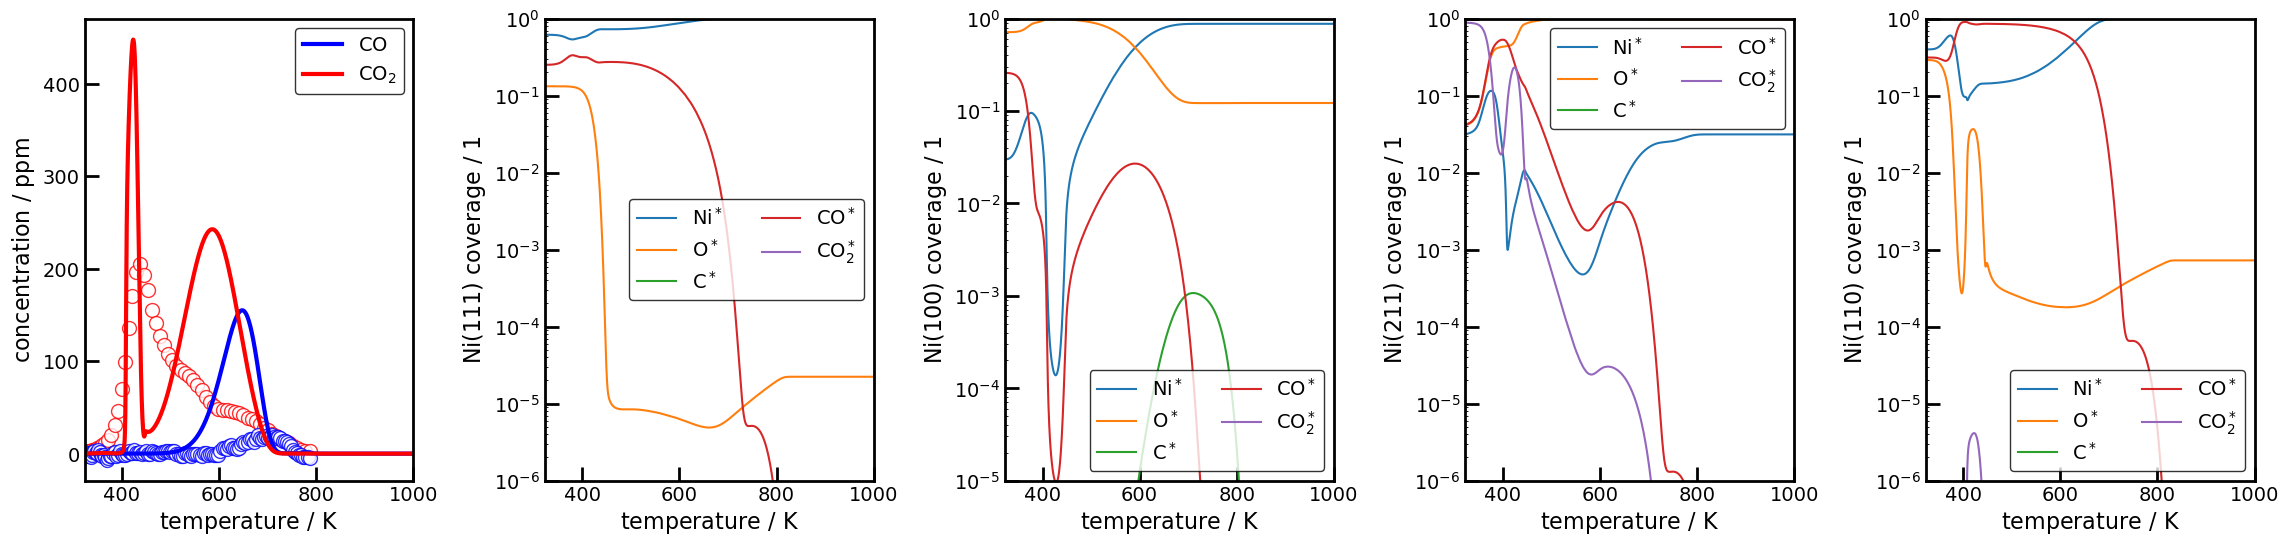

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd 

plt.rcParams['figure.figsize']=(7,6)
plt.rcParams['axes.titlesize']=16
plt.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.major.width']=2
plt.rcParams['legend.edgecolor']='k'


plt.rcParams['figure.figsize']=(28,6)
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.4)
ax0 = plt.subplot(gs[0])

NiSiO2=pd.read_csv("experiment/2020722_nisio2_1b_co2_adsorption_flow_tpd.txt", sep="\t", header=1)
NiSiO2.columns=['Temp', 'CO2', 'CO']
ax0.plot(NiSiO2.Temp[::20]+273, NiSiO2.CO2[::20]*1e4, markeredgecolor='r',markerfacecolor='w', linestyle='None', marker='o', alpha=0.8)
ax0.plot(NiSiO2.Temp[::10]+273, (NiSiO2.CO[::10]-np.mean(NiSiO2.CO[0:50]))*1e4*4,  markeredgecolor='b', markerfacecolor='w', linestyle='None', marker='o', alpha=0.8)
ax1 = plt.subplot(gs[4])     
ax2 = plt.subplot(gs[1]) 
ax3 = plt.subplot(gs[2]) 
ax4 = plt.subplot(gs[3]) 

idx=5410
ax0.plot(Ti[idx:], gas_mole_fracs[i_co,idx:]*100*10000, label='$\mathrm{CO}$', color='b', linewidth=3)
ax0.plot(Ti[idx:], gas_mole_fracs[i_co2,idx:]*100*10000, label='$\mathrm{CO_2}$',color='r', linewidth=3)
ax0.set_xlabel('$\mathrm{temperature\ /\ K}$')
ax0.set_xlim([323, 1000])
#ax0.set_ylim([0, 2])
ax0.set_ylabel('$\mathrm{concentration}\ /\ \mathrm{ppm}$')
ax0.legend()

#ax1.plot(Ti[idx:], r_100[0,idx:],color='r', label='CO2')
#ax1.plot(Ti[idx:], r_100[1,idx:], color='b', label='CO')
#ax1.plot(Ti[idx:], r_100[2,idx:], color='g', label='CO2 diss')
#ax1.plot(Ti[idx:], r_100[0,idx:],color='r', Linestyle='dashed', label='CO2')
#ax1.plot(Ti[idx:], r_100[1,idx:], color='b',Linestyle='dashed', label='CO')
#ax1.plot(Ti[idx:], r_100[2,idx:], color='g',Linestyle='dashed', label='CO2 diss')
#ax1.set_ylim([-10e-11, -1e-12])
#ax1.set_xlim([430, 480])

ax2.semilogy(Ti[idx:], surf_fracs111[i_surf_Ni,idx:], label='$\mathrm{Ni^*}$')
ax2.semilogy(Ti[idx:], surf_fracs111[i_surf_O,idx:], label='$\mathrm{O^*}$')
ax2.semilogy(Ti[idx:], surf_fracs111[i_surf_C,idx:], label='$\mathrm{C^*}$')
ax2.semilogy(Ti[idx:], surf_fracs111[i_surf_CO,idx:], label='$\mathrm{CO^*}$')
ax2.semilogy(Ti[idx:], surf_fracs111[i_surf_CO2,idx:], label='$\mathrm{CO_2^*}$')
ax2.set_xlabel('$\mathrm{temperature\ /\ K}$')
ax2.set_ylabel('$\mathrm{Ni(111)\ coverage}\ /\ \mathrm{1}$')
ax2.set_xlim([323, 1000])
ax2.set_ylim([1e-6, 1e0])
ax2.legend(ncol=2)

ax3.semilogy(Ti[idx:], surf_fracs100[i_surf_Ni,idx:], label='$\mathrm{Ni^*}$')
ax3.semilogy(Ti[idx:], surf_fracs100[i_surf_O,idx:], label='$\mathrm{O^*}$')
ax3.semilogy(Ti[idx:], surf_fracs100[i_surf_C,idx:], label='$\mathrm{C^*}$')
ax3.semilogy(Ti[idx:], surf_fracs100[i_surf_CO,idx:], label='$\mathrm{CO^*}$')
ax3.semilogy(Ti[idx:], surf_fracs100[i_surf_CO2,idx:], label='$\mathrm{CO_2^*}$')
ax3.set_xlabel('$\mathrm{temperature\ /\ K}$')
ax3.set_ylabel('$\mathrm{Ni(100)\ coverage}\ /\ \mathrm{1}$')
ax3.set_xlim([323, 1000])
ax3.set_ylim([1e-5, 1e0])
ax3.legend(ncol=2)

ax4.semilogy(Ti[idx:], surf_fracs211[i_surf_Ni,idx:], label='$\mathrm{Ni^*}$')
ax4.semilogy(Ti[idx:], surf_fracs211[i_surf_O,idx:], label='$\mathrm{O^*}$')
ax4.semilogy(Ti[idx:], surf_fracs211[i_surf_C,idx:], label='$\mathrm{C^*}$')
ax4.semilogy(Ti[idx:], surf_fracs211[i_surf_CO,idx:], label='$\mathrm{CO^*}$')
ax4.semilogy(Ti[idx:], surf_fracs211[i_surf_CO2,idx:], label='$\mathrm{CO_2^*}$')
ax4.set_xlabel('$\mathrm{temperature\ /\ K}$')
ax4.set_ylabel('$\mathrm{Ni(211)\ coverage}\ /\ \mathrm{1}$')
ax4.set_xlim([323, 1000])
ax4.set_ylim([1e-6, 1e0])
ax4.legend(ncol=2)

ax1.semilogy(Ti[idx:], surf_fracs110[i_surf_Ni,idx:], label='$\mathrm{Ni^*}$')
ax1.semilogy(Ti[idx:], surf_fracs110[i_surf_O,idx:], label='$\mathrm{O^*}$')
ax1.semilogy(Ti[idx:], surf_fracs110[i_surf_C,idx:], label='$\mathrm{C^*}$')
ax1.semilogy(Ti[idx:], surf_fracs110[i_surf_CO,idx:], label='$\mathrm{CO^*}$')
ax1.semilogy(Ti[idx:], surf_fracs110[i_surf_CO2,idx:], label='$\mathrm{CO_2^*}$')
ax1.set_xlabel('$\mathrm{temperature\ /\ K}$')
ax1.set_ylabel('$\mathrm{Ni(110)\ coverage}\ /\ \mathrm{1}$')
ax1.set_xlim([323, 1000])
ax1.set_ylim([1e-6, 1e0])
ax1.legend(ncol=2)
plt.savefig('TPD_CO2_Multifacet_SD_surface.pdf', bbox_inches='tight')
plt.show()